### Objective and Dataset

**Objective:** The goal of this project is to train and evaluate a YOLOv8 object detector on a custom two-class dataset. The model must learn to accurately identify and locate 'person' and 'car' objects within images.

**Dataset:** The dataset is provided in YOLO format, which includes images and corresponding label files. It is pre-split into `train`, `val`, and `test` sets, ensuring a standardized evaluation process. This notebook prepares the data by creating a `data.yaml` configuration file that points the training process to the correct directories and defines the class names.

In [7]:
!nvidia-smi
!pip install -q ultralytics==8.2.103
from ultralytics import YOLO
from pathlib import Path
import os, yaml, glob, shutil
HOME = Path("/content")


Sun Oct 19 08:57:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
!unzip -q -o /content/data.zip -d /content

import shutil, os
if os.path.isdir("/content/data/data/train"):
    !rsync -a /content/data/data/ /content/data/
    !rm -rf /content/data/data


In [9]:
# Quick listing
!ls -la /content/data
!ls -la /content/data/train | head -n 20


total 44
drwxr-xr-x 7 root root 4096 Oct 19 08:57 .
drwxr-xr-x 1 root root 4096 Oct 19 08:57 ..
-rw-r--r-- 1 root root   68 Aug 12  2022 data.yaml
drwxr-xr-x 2 root root 4096 Oct 19 08:57 .ipynb_checkpoints
-rw-r--r-- 1 root root  201 Aug 12  2022 README.dataset.txt
-rw-r--r-- 1 root root  786 Aug 12  2022 README.roboflow.txt
drwxr-xr-x 4 root root 4096 Oct 17 22:59 test
drwxr-xr-x 4 root root 4096 Oct 17 22:59 train
drwxr-xr-x 4 root root 4096 Oct 17 22:59 val
drwxr-xr-x 4 root root 4096 Oct 17 22:59 valid
total 320
drwxr-xr-x 4 root root   4096 Oct 17 22:59 .
drwxr-xr-x 7 root root   4096 Oct 19 08:57 ..
drwxr-xr-x 2 root root 163840 Oct 19 08:57 images
drwxr-xr-x 2 root root 155648 Oct 19 08:57 labels


### Model and Training Setup

**Model:** We are using `YOLOv8s`, the "small" version of the YOLOv8 family. This model offers a strong balance between speed and accuracy, making it suitable for real-time applications and feasible to train within a limited time frame. We start with weights pre-trained on the COCO dataset to leverage transfer learning.

**Training Configuration:**
- **Epochs:** The model is trained for 60 epochs.
- **Image Size:** Input images are resized to `640x640` pixels.
- **Batch Size:** A batch size of 16 is used to balance training speed and memory usage.
- **Device:** Training is performed on a GPU to accelerate the process significantly.

In [34]:
import yaml
import os
from pathlib import Path


corrected_yaml_data = {
    'train': '/content/data/train/images',
    'val': '/content/data/val/images',
    'test': '/content/data/test/images',
    'nc': 2,
}

path1 = Path("/content/data/data/data.yaml")
path1.parent.mkdir(parents=True, exist_ok=True)
with open(path1, "w") as f:
    yaml.dump(corrected_yaml_data, f)
print(f"SUCCESS: Created/Overwrote file at: {path1}")

path2 = Path("/content/data/data.yaml")
with open(path2, "w") as f:
    yaml.dump(corrected_yaml_data, f)
print(f"SUCCESS: Created/Overwrote file at: {path2}")

print("\n--- Verifying contents of the key file ---")
!cat /content/data/data/data.yaml

SUCCESS: Created/Overwrote file at: /content/data/data/data.yaml
SUCCESS: Created/Overwrote file at: /content/data/data.yaml

--- Verifying contents of the key file ---
nc: 2
test: /content/data/test/images
train: /content/data/train/images
val: /content/data/val/images


In [11]:

# Train
!yolo task=detect mode=train model=yolov8s.pt data="/content/data/data.yaml" epochs=60 imgsz=640 batch=16 device=0


New https://pypi.org/project/ultralytics/8.3.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/data/data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

### Evaluation and Results

**Metrics:** We evaluate the model's performance using standard object detection metrics:
- **Precision:** Of all the predictions the model made, how many were correct? (TP / (TP + FP))
- **Recall:** Of all the actual objects in the images, how many did the model find? (TP / (TP + FN))
- **mAP@0.5 (Mean Average Precision):** This is the primary metric. It measures the average precision across all classes at an Intersection over Union (IoU) threshold of 50%. It rewards the model for correctly identifying objects, even if the bounding box isn't perfectly placed.
- **mAP@0.5:0.95:** A stricter metric that averages the mAP across ten different IoU thresholds (from 0.5 to 0.95). It heavily penalizes inaccurate bounding box placement.

**Key Results:** The training and validation plots provide insight into the model's performance. The `results.png` chart shows how metrics like precision, recall, and mAP improved over the 60 epochs. The `PR_curve.png` shows the precision-recall trade-off for each class, while the `confusion_matrix.png` details what kinds of errors the model makes (e.g., confusing a person with the background).

**Error Analysis & Next Steps:**
Based on the qualitative results in the prediction gallery, we can analyze the model's common failure modes.
1.  **Challenge:** The model sometimes struggles with very small or distant objects, leading to missed detections (False Negatives).
2.  **Challenge:** Heavily occluded objects (e.g., a person mostly hidden behind a car) are difficult to detect correctly.
3.  **Next Steps for Improvement:**
    - Increase the training `imgsz` to 1280 to help the model see smaller objects more clearly.
    - Train for more epochs (e.g., 100) to allow the model to converge further.
    - Introduce more advanced data augmentations to create more challenging training examples.

Ultralytics YOLOv8.2.103 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/data/val/labels.cache... 448 images, 0 backgrounds, 0 corrupt: 100% 448/448 [00:00<?, ?it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 28/28 [04:15<00:00,  9.12s/it]
                   all        448       3442      0.734      0.604      0.653      0.376
                     1        448       2179      0.713      0.567      0.615      0.302
                     2        448       1263      0.755       0.64      0.691      0.451
Speed: 6.1ms preprocess, 556.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to 

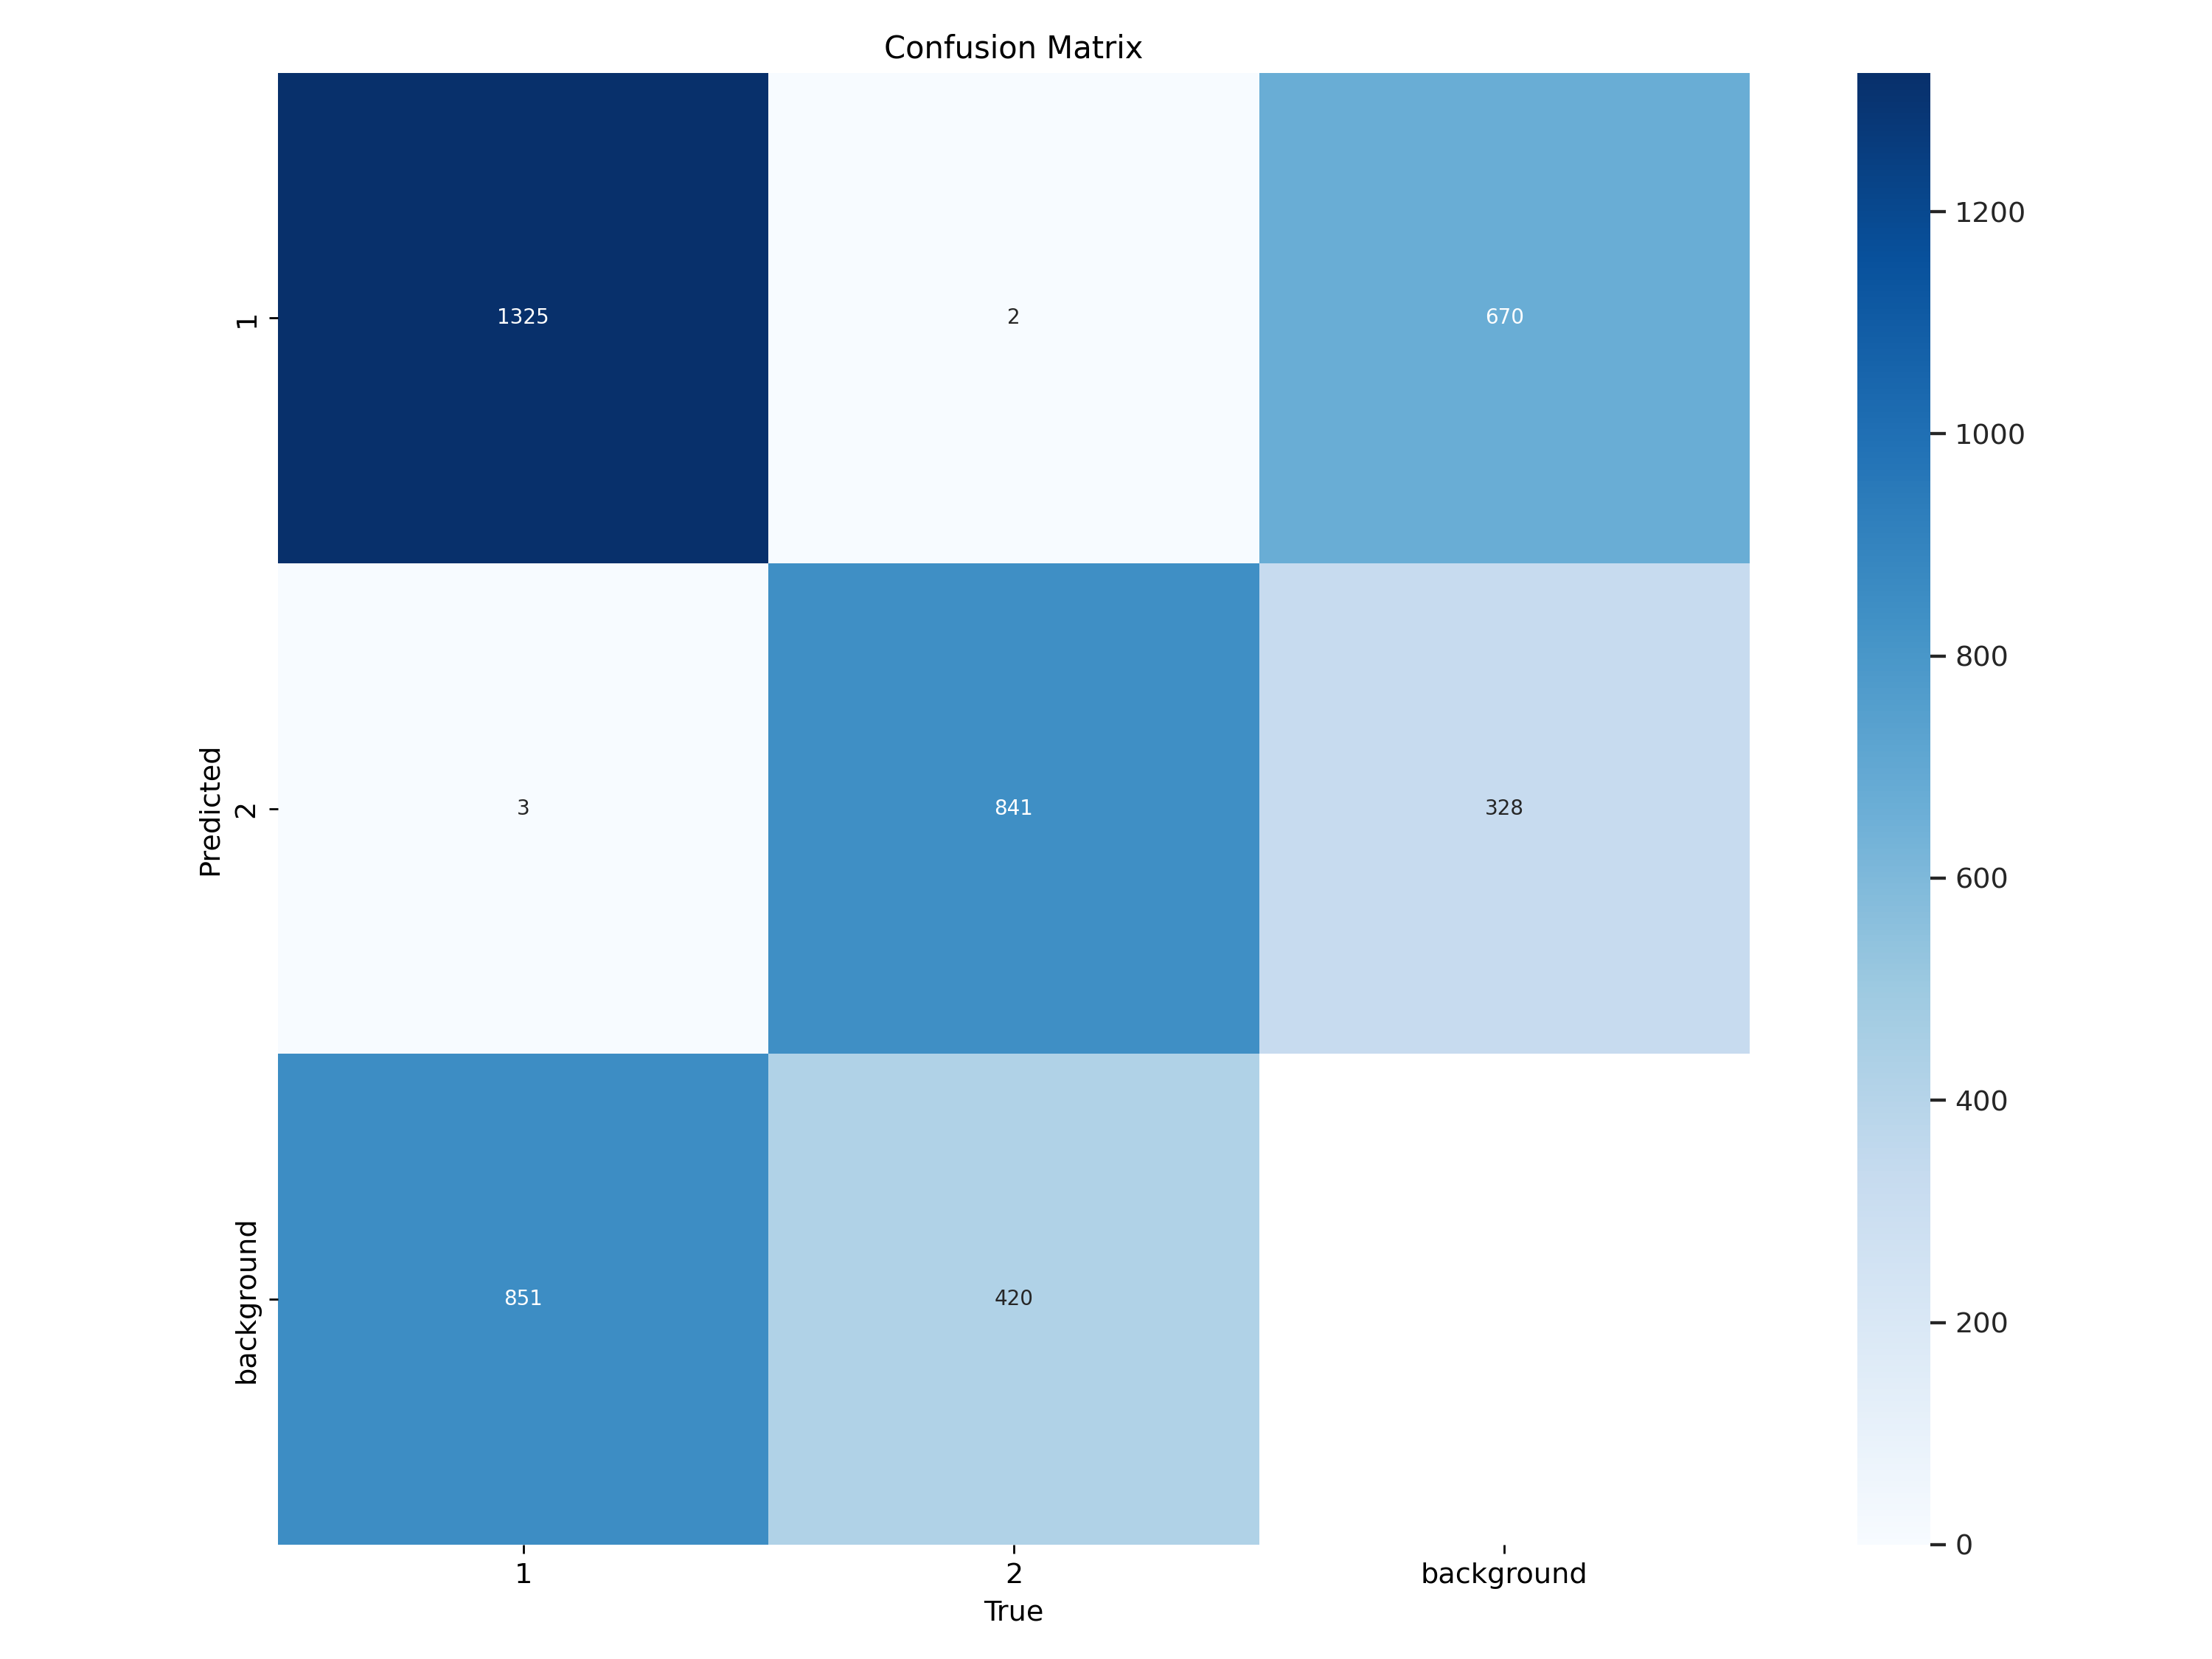

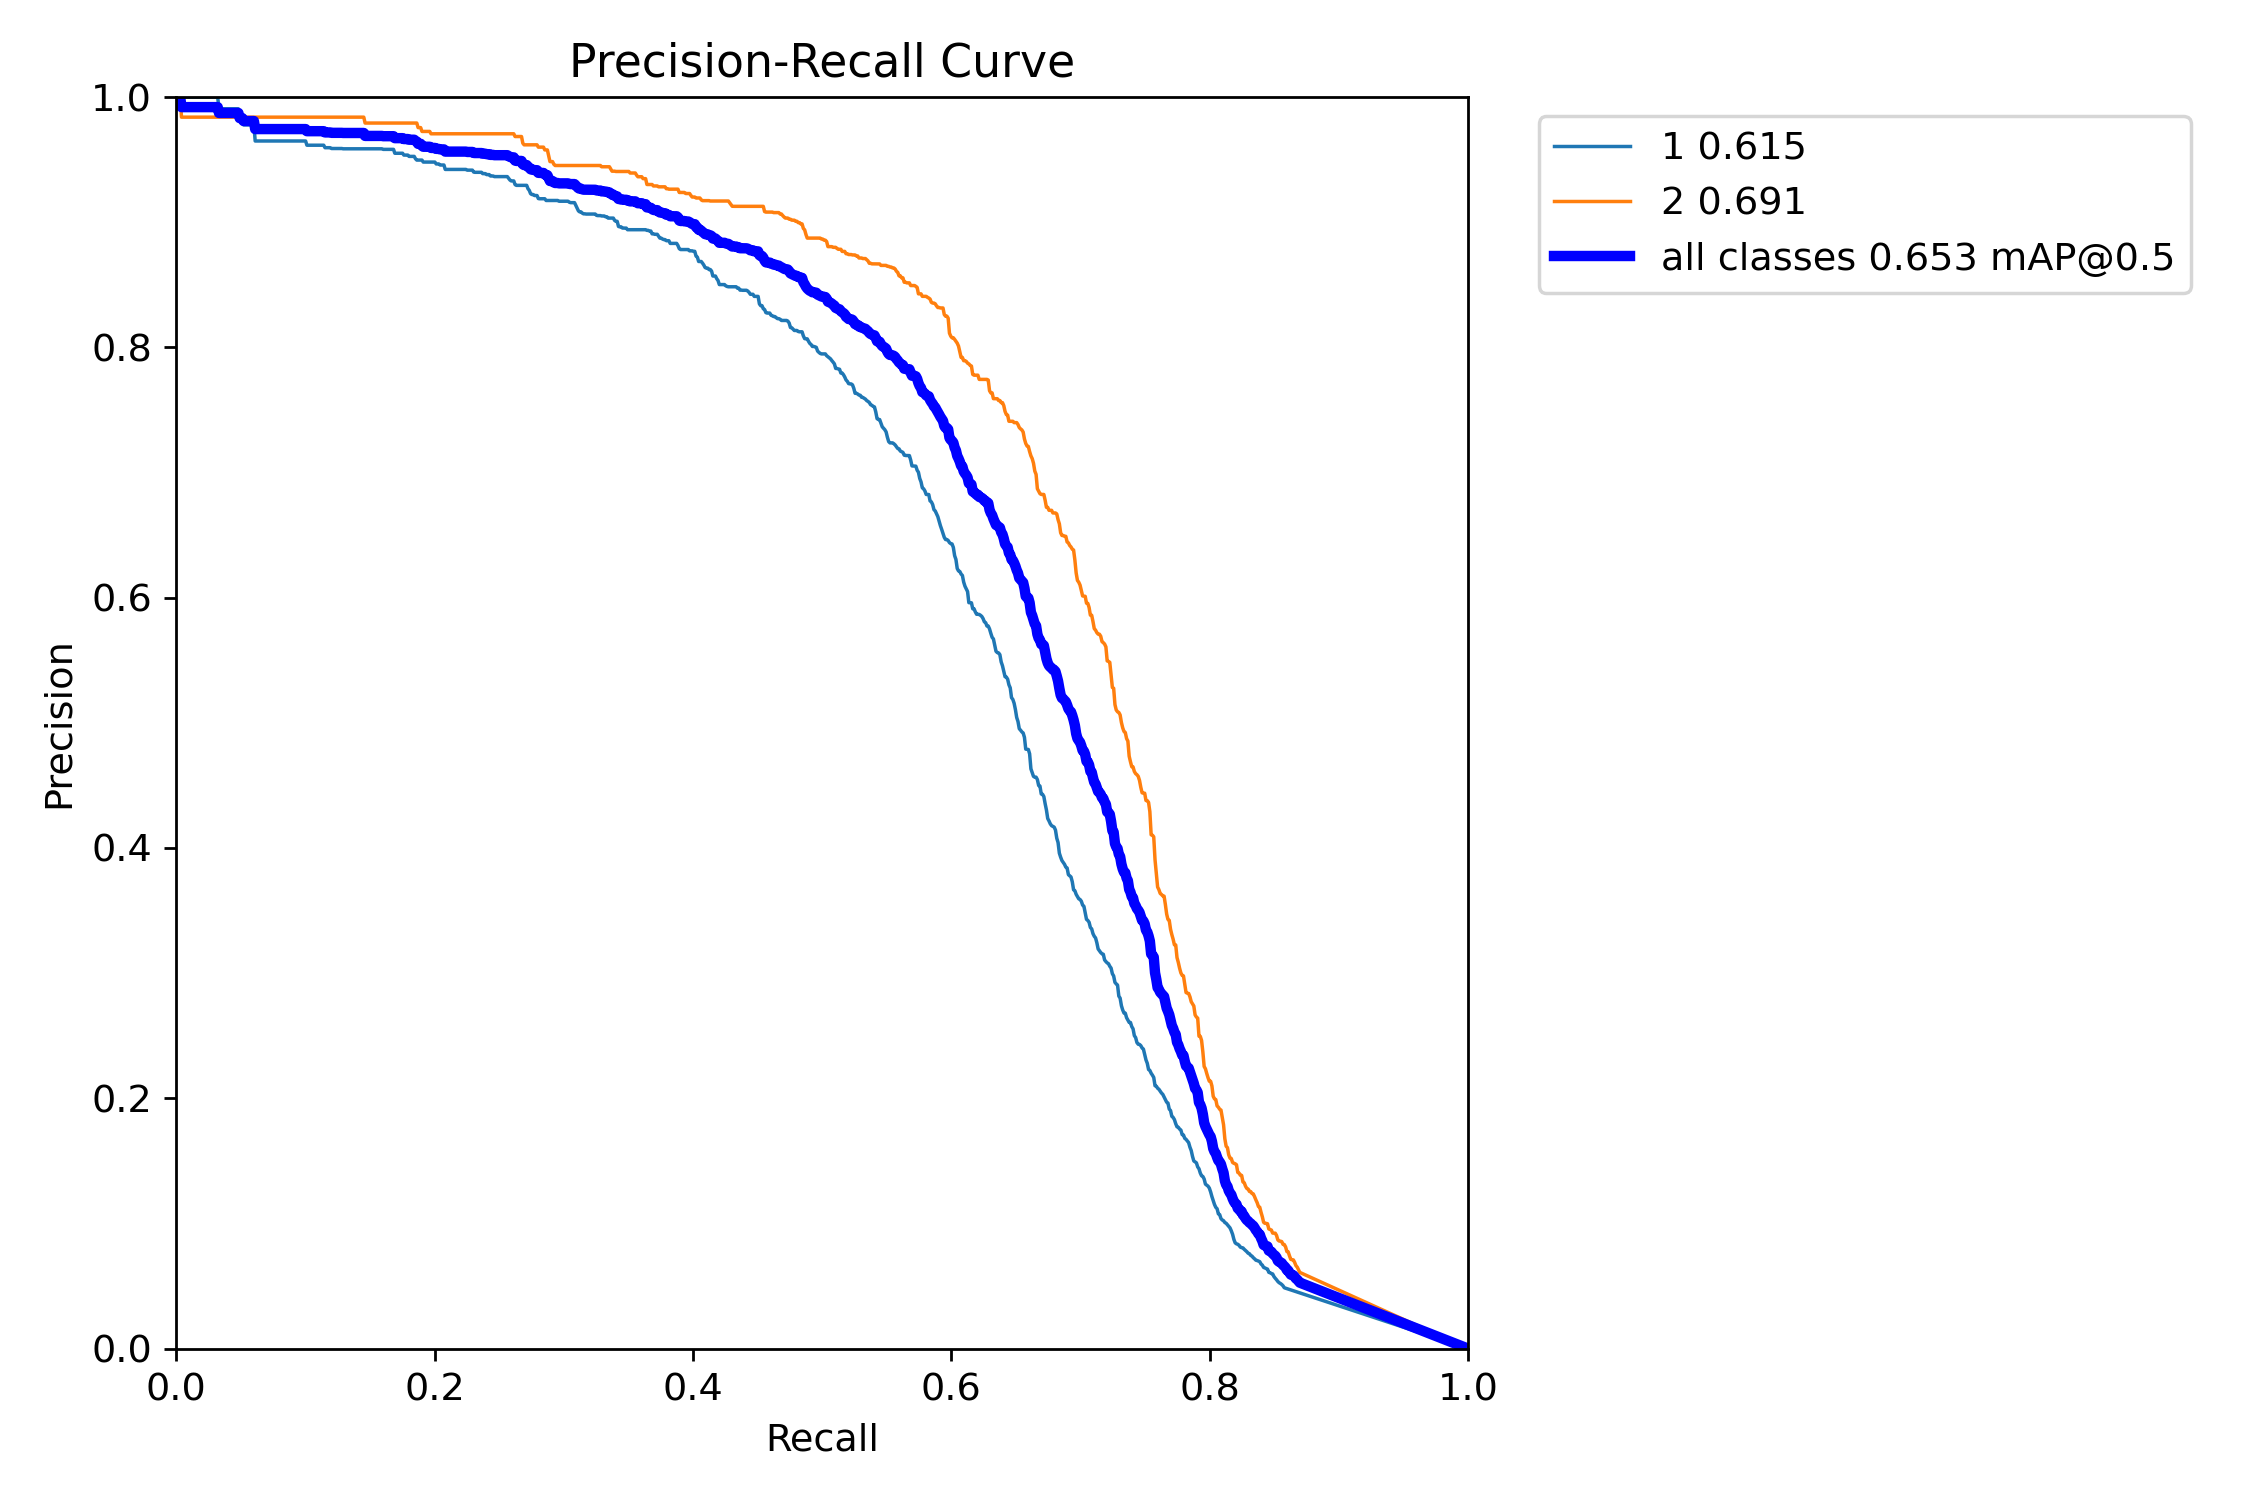

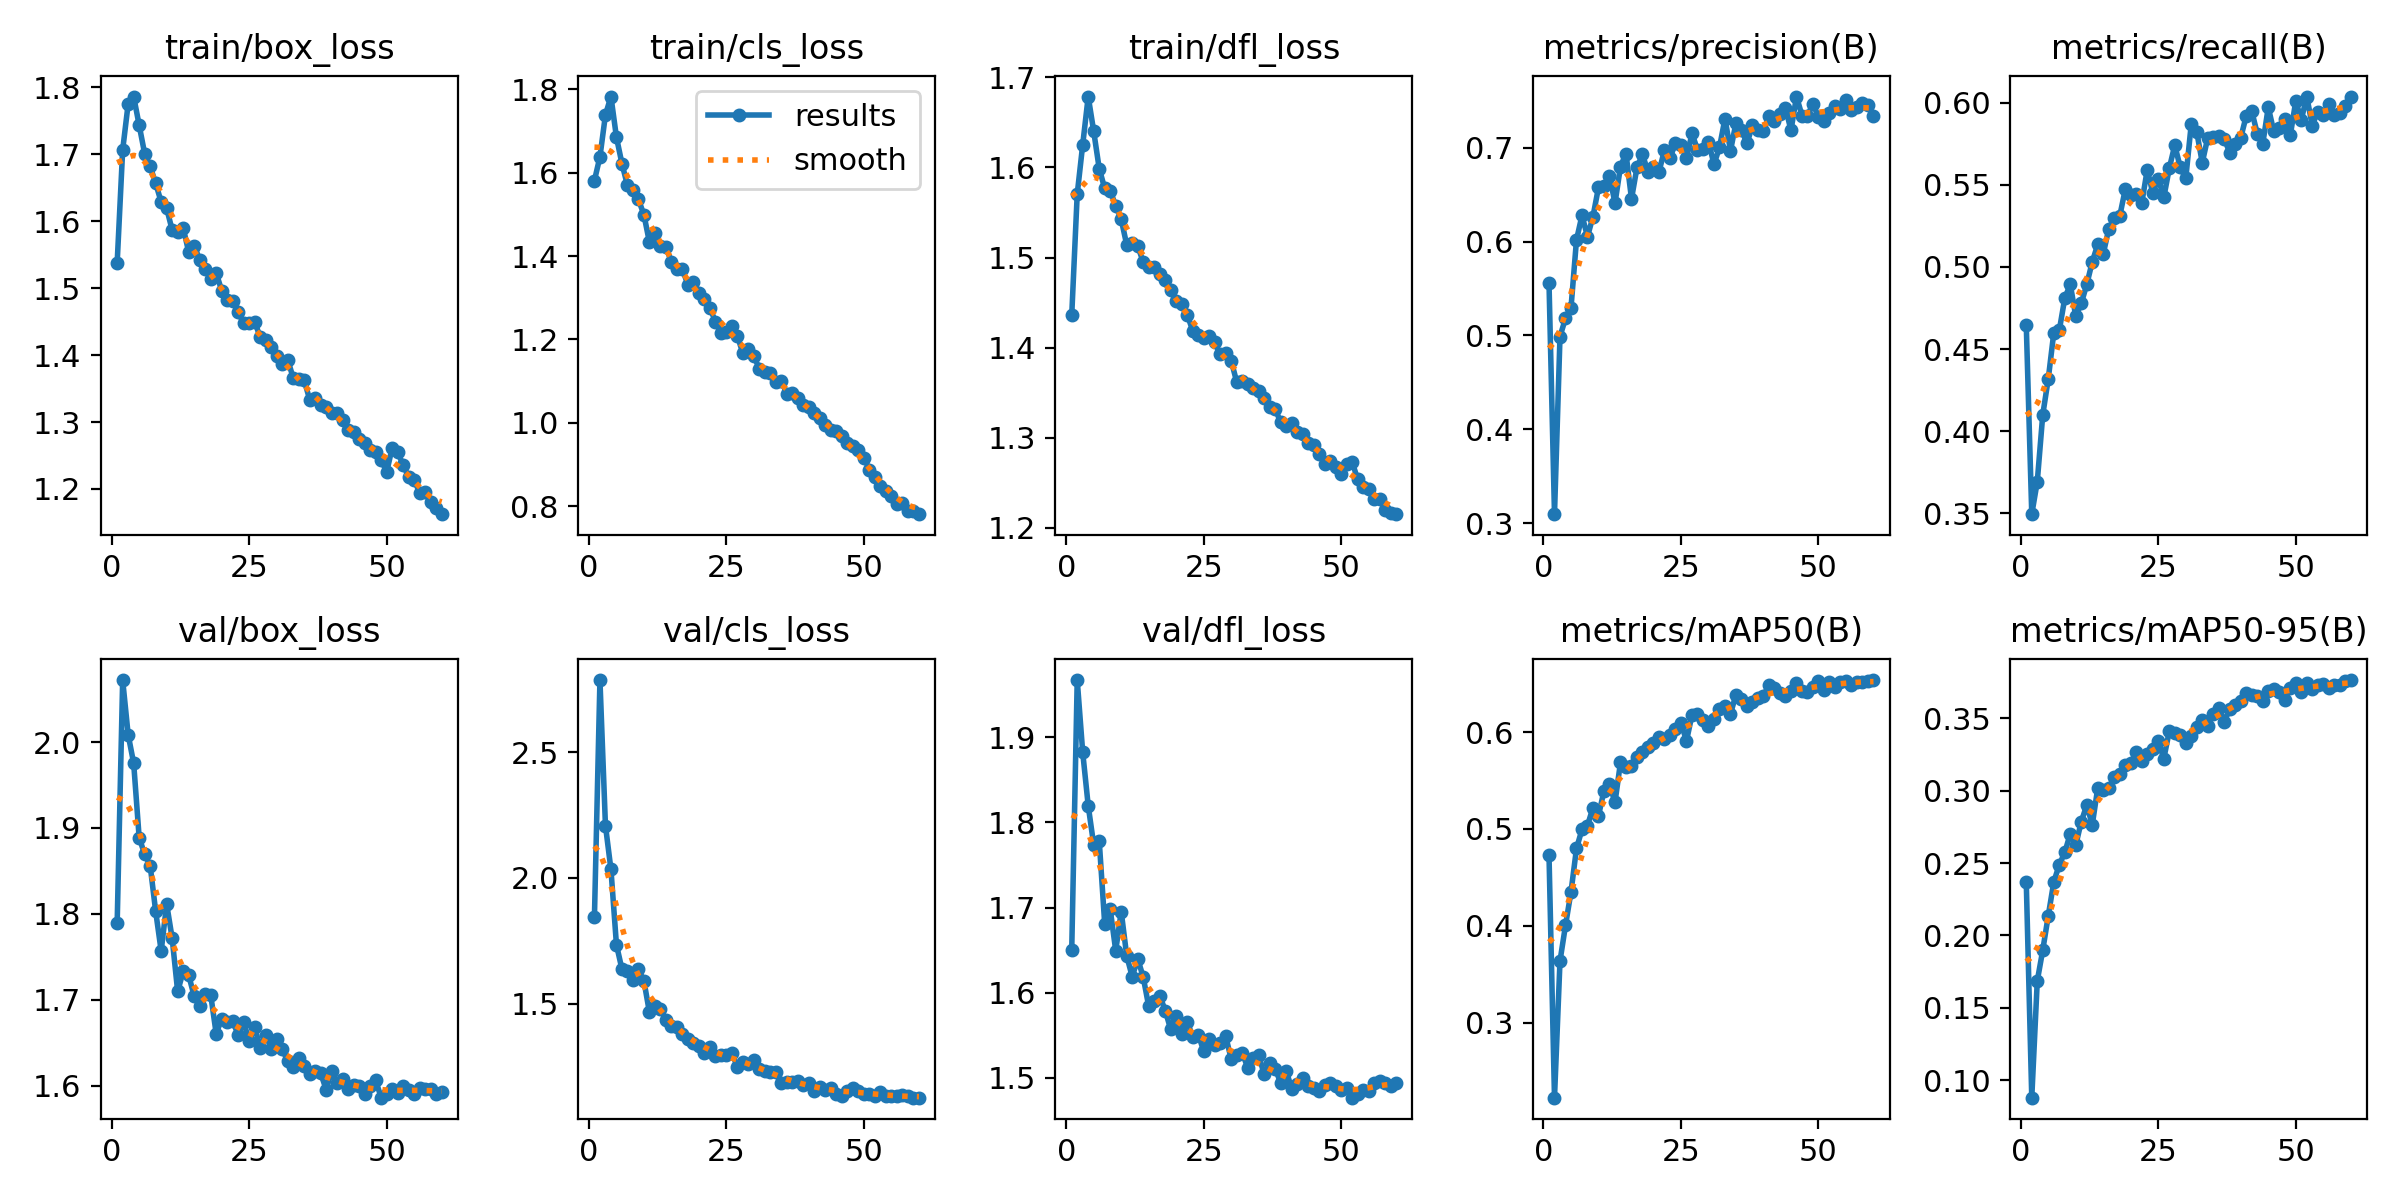

In [28]:
from IPython.display import display, Image
import os

TRAIN_RUN_DIR = "runs/detect/train2"
BEST_MODEL_PATH = f"{TRAIN_RUN_DIR}/weights/best.pt"

CORRECT_DATA_PATH = "/content/data/data.yaml"

!yolo task=detect mode=val model={BEST_MODEL_PATH} data={CORRECT_DATA_PATH} name="final_validation"

!yolo task=detect mode=predict model={BEST_MODEL_PATH} data={CORRECT_DATA_PATH} source="/content/data/test/images" name="final_predictions"

VALIDATION_RUN_DIR = "runs/detect/final_validation"

print(f"\n--- Displaying Plots from {VALIDATION_RUN_DIR} ---")
if os.path.exists(f'{VALIDATION_RUN_DIR}/confusion_matrix.png'):
    display(Image(filename=f'{VALIDATION_RUN_DIR}/confusion_matrix.png', width=800))
    display(Image(filename=f'{VALIDATION_RUN_DIR}/PR_curve.png', width=800))

    display(Image(filename=f'{TRAIN_RUN_DIR}/results.png', width=800))
else:
    print(f"ERROR: Could not find plots in {VALIDATION_RUN_DIR}. Check the run name in the output above.")

Displaying 8 sample predictions from 'runs/detect/final_predictions':


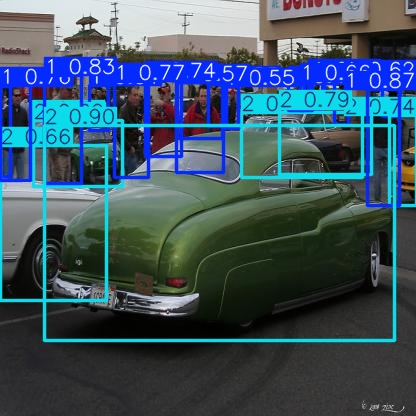

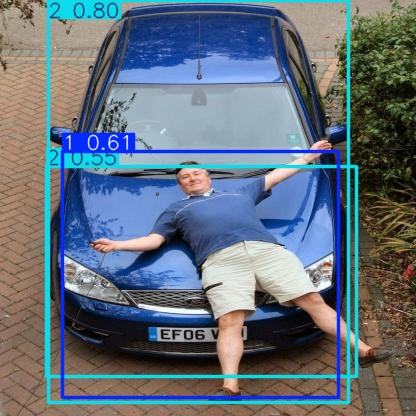

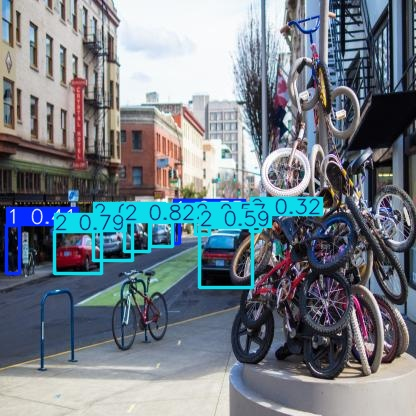

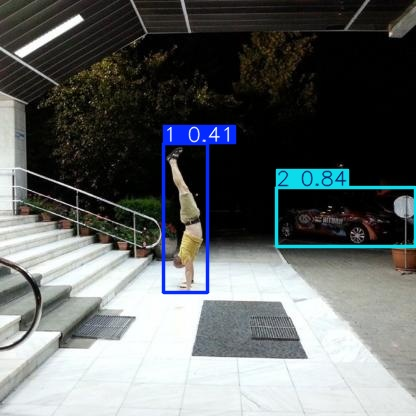

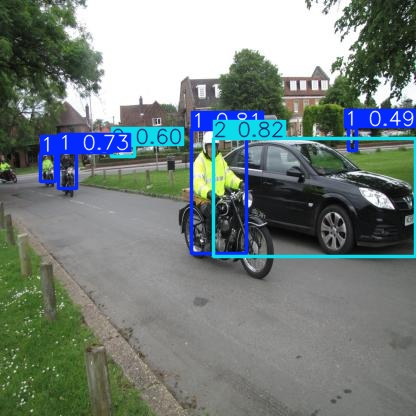

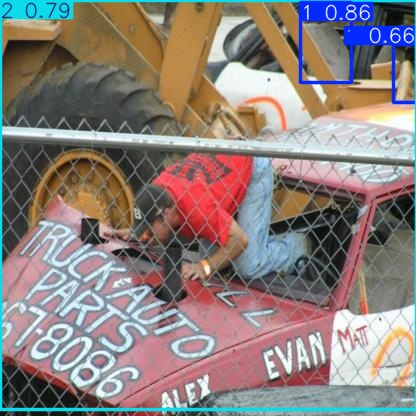

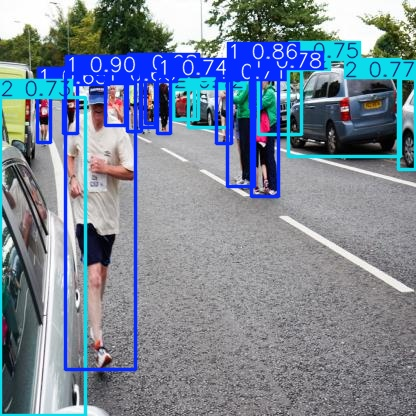

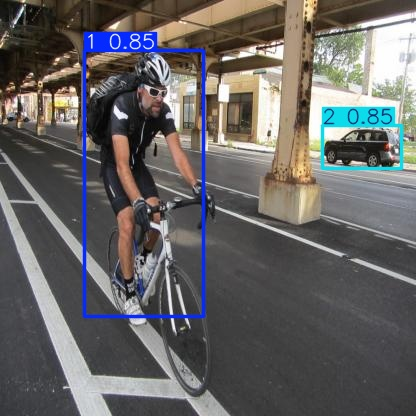

In [33]:
import glob
from IPython.display import Image, display


PREDICT_RUN_DIR = "runs/detect/final_predictions"


image_files = sorted(glob.glob(f"{PREDICT_RUN_DIR}/*.jpg"))[:8]

if not image_files:
    print(f"ERROR: No prediction images found in {PREDICT_RUN_DIR}. Please check the folder name.")
else:
    print(f"Displaying {len(image_files)} sample predictions from '{PREDICT_RUN_DIR}':")
    for img_path in image_files:

        display(Image(filename=img_path, width=600))

In [13]:
!yolo task=detect mode=predict model=runs/detect/train2/weights/best.pt conf=0.35 source="/content/data/val/images"


Ultralytics YOLOv8.2.103 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs

image 1/448 /content/data/val/images/image_000000001_jpg.rf.02ab6664294833e5f0e89130ecded0b8.jpg: 640x640 1 1, 2 2s, 15.9ms
image 2/448 /content/data/val/images/image_000000002_jpg.rf.8270179e3cd29b97cf502622b381861e.jpg: 640x640 3 2s, 15.9ms
image 3/448 /content/data/val/images/image_000000003_jpg.rf.db8fd4730b031e35a60e0a60e17a0691.jpg: 640x640 8 1s, 15.9ms
image 4/448 /content/data/val/images/image_000000005_jpg.rf.78faf35ae818cfb31529481b1aa24717.jpg: 640x640 10 1s, 1 2, 15.8ms
image 5/448 /content/data/val/images/image_000000010_jpg.rf.bd4b622b644255e6c229402ae5a7b8a2.jpg: 640x640 2 1s, 15.8ms
image 6/448 /content/data/val/images/image_000000013_jpg.rf.596954d88b03ca3af5793b6fdcaa49eb.jpg: 640x640 7 1s, 4 2s, 15.9ms
image 7/448 /content/data/val/images/image_000000017_jpg.rf.607c0082ee6d37a3192c7a9966bffc69.jpg:

In [14]:
from ultralytics import YOLO
YOLO("runs/detect/train2/weights/best.pt").export(format="onnx", dynamic=True, opset=12)


Ultralytics YOLOv8.2.103 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from 'runs/detect/train2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (21.5 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim==0.1.34', 'onnxruntime'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 352.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 338.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 322.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 384.3 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 8.2s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim==0.1.34', 'onnxruntime']
requirements: ⚠️ Restart runtime or rerun com

'runs/detect/train2/weights/best.onnx'

In [18]:

from ultralytics import YOLO
from IPython.display import display, Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob, os, re, numpy as np


model_path = "runs/detect/train2/weights/best.pt"
source_dir = "/content/data/val/images"
conf = 0.35

!yolo task=detect mode=predict model="{model_path}" conf={conf} source="{source_dir}" save=True



Ultralytics YOLOv8.2.103 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs

image 1/448 /content/data/val/images/image_000000001_jpg.rf.02ab6664294833e5f0e89130ecded0b8.jpg: 640x640 1 1, 2 2s, 396.0ms
image 2/448 /content/data/val/images/image_000000002_jpg.rf.8270179e3cd29b97cf502622b381861e.jpg: 640x640 3 2s, 353.3ms
image 3/448 /content/data/val/images/image_000000003_jpg.rf.db8fd4730b031e35a60e0a60e17a0691.jpg: 640x640 8 1s, 340.6ms
image 4/448 /content/data/val/images/image_000000005_jpg.rf.78faf35ae818cfb31529481b1aa24717.jpg: 640x640 10 1s, 1 2, 352.3ms
image 5/448 /content/data/val/images/image_000000010_jpg.rf.bd4b622b644255e6c229402ae5a7b8a2.jpg: 640x640 2 1s, 342.0ms
image 6/448 /content/data/val/images/image_000000013_jpg.rf.596954d88b03ca3af5793b6fdcaa49eb.jpg: 640x640 7 1s, 4 2s, 510.8ms
image 7/448 /content/data/val/images/image_000000017_jpg.rf.607c0082ee6d37a3192c7a9966bffc69.j

In [20]:
def latest_predict_dir():
    preds = glob.glob("runs/detect/predict*")
    if not preds:
        raise SystemExit("No predict folder found. Run the predict step above first.")
    def sort_key(p):
        m = re.search(r"predict(\d+)?$", p)
        n = int(m.group(1)) if m and m.group(1) else 0
        return (n, os.path.getmtime(p))
    return sorted(preds, key=sort_key)[-1]

pred_dir = latest_predict_dir()
print("Showing from:", pred_dir)

# 2) Pick exactly 4 images
img_exts = ("*.jpg", "*.jpeg", "*.png", "*.bmp")
imgs = []
for ext in img_exts:
    imgs.extend(glob.glob(os.path.join(pred_dir, ext)))
imgs = sorted(imgs)[:4]
if not imgs:
    raise SystemExit("No images found in predict outputs. Check your source directory.")


Showing from: runs/detect/predict4


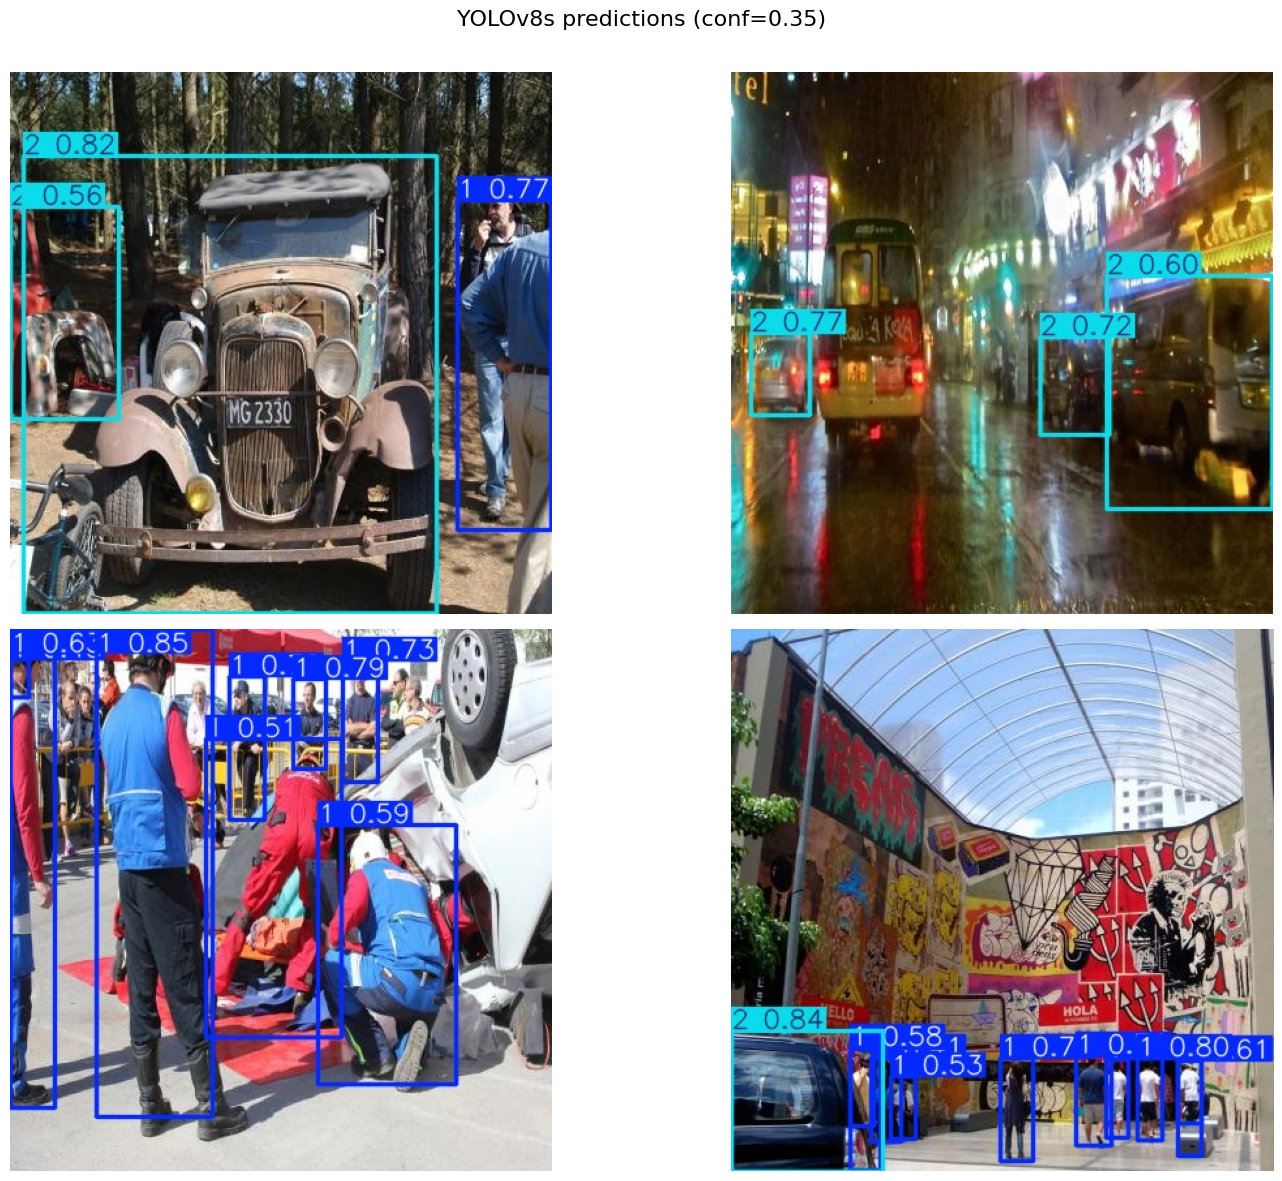

In [21]:
def show_grid_clean(images, rows=2, cols=2, figsize=(16, 12), title=None):
    plt.figure(figsize=figsize)
    if title:
        plt.suptitle(title, fontsize=16, y=0.98)
    for i, p in enumerate(images, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(mpimg.imread(p))
        plt.axis("off")
    plt.tight_layout(rect=[0, 0, 1, 0.97] if title else None)
    plt.show()

show_grid_clean(imgs, rows=2, cols=2, figsize=(16, 12), title=f"YOLOv8s predictions (conf={conf})")


In [35]:
import os
import shutil
import glob
from pathlib import Path

HOME = Path("/content")

TRAIN_RUN_DIR = "runs/detect/train2"
PREDICT_RUN_DIR = "runs/detect/predict4"

EXPORT_DIR = HOME / "export_bundle"
if EXPORT_DIR.exists():
    shutil.rmtree(EXPORT_DIR)
os.makedirs(EXPORT_DIR / "weights", exist_ok=True)
os.makedirs(EXPORT_DIR / "plots", exist_ok=True)
os.makedirs(EXPORT_DIR / "predictions", exist_ok=True)

print("Assembling the deliverables bundle...")

BEST_MODEL_PATH = f"{TRAIN_RUN_DIR}/weights/best.pt"
if os.path.exists(BEST_MODEL_PATH):
    shutil.copy(BEST_MODEL_PATH, EXPORT_DIR / "weights/best.pt")
    print("Copied best.pt")
else:
    print(f"ERROR: Model not found at {BEST_MODEL_PATH}. Please check TRAIN_RUN_DIR.")

plots_to_copy = ["results.png", "confusion_matrix.png", "PR_curve.png"]
for plot_name in plots_to_copy:
    plot_path = f"{TRAIN_RUN_DIR}/{plot_name}"
    if os.path.exists(plot_path):
        shutil.copy(plot_path, EXPORT_DIR / "plots/")
        print(f"Copied {plot_name}")
    else:
        print(f"WARNING: Plot '{plot_name}' not found in {TRAIN_RUN_DIR}.")

pred_images = sorted(glob.glob(f"{PREDICT_RUN_DIR}/*.jpg"))[:10]
if pred_images:
    for img_path in pred_images:
        shutil.copy(img_path, EXPORT_DIR / "predictions/")
    print(f"Copied {len(pred_images)} sample prediction images.")
else:
    print(f"ERROR: No prediction images found in {PREDICT_RUN_DIR}. Please check PREDICT_RUN_DIR.")

DATA_YAML_PATH = "/content/data/data.yaml"
if os.path.exists(DATA_YAML_PATH):
    shutil.copy(DATA_YAML_PATH, EXPORT_DIR / "data.yaml")
    print("Copied data.yaml")
else:
    print(f"WARNING: {DATA_YAML_PATH} not found.")

print("\n--- Final Bundle Contents ---")
!ls -R {EXPORT_DIR}

print("\nZipping the bundle...")
!zip -r export_bundle.zip {EXPORT_DIR}

print("\n---")
print("DONE. Find and download 'export_bundle.zip' from the file browser on the left side of Colab.")



Assembling the deliverables bundle...
Copied best.pt
Copied results.png
Copied confusion_matrix.png
Copied PR_curve.png
Copied 10 sample prediction images.
Copied data.yaml

--- Final Bundle Contents ---
/content/export_bundle:
data.yaml  plots  predictions  weights

/content/export_bundle/plots:
confusion_matrix.png  PR_curve.png  results.png

/content/export_bundle/predictions:
image_000000001_jpg.rf.02ab6664294833e5f0e89130ecded0b8.jpg
image_000000002_jpg.rf.8270179e3cd29b97cf502622b381861e.jpg
image_000000003_jpg.rf.db8fd4730b031e35a60e0a60e17a0691.jpg
image_000000005_jpg.rf.78faf35ae818cfb31529481b1aa24717.jpg
image_000000010_jpg.rf.bd4b622b644255e6c229402ae5a7b8a2.jpg
image_000000013_jpg.rf.596954d88b03ca3af5793b6fdcaa49eb.jpg
image_000000017_jpg.rf.607c0082ee6d37a3192c7a9966bffc69.jpg
image_000000019_jpg.rf.ccbdc59e6b469d5c0b0ef8bae0f9d62b.jpg
image_000000022_jpg.rf.7d5b8cf7ee87ad3a595adf8d1b35277d.jpg
image_000000024_jpg.rf.6a4bf4926a9ffe6f714f52909f148563.jpg

/content/export_

In [36]:
import os
from pathlib import Path

# The directory to be zipped is '/content', which is the main working directory.
TARGET_DIR = "/content"
OUTPUT_ZIP_NAME = "complete_project_backup.zip"
OUTPUT_ZIP_PATH = f"{TARGET_DIR}/{OUTPUT_ZIP_NAME}"

print(f"Starting to zip the entire '{TARGET_DIR}' directory...")
print("This may take a few moments depending on the size of your data.")

# We use the zip command to archive the entire /content directory.
# The '-x' flag is important to exclude the output zip file itself from being included in the archive.
zip_command = f"zip -r {OUTPUT_ZIP_PATH} {TARGET_DIR} -x '{OUTPUT_ZIP_PATH}'"

# Execute the command using get_ipython() to run shell commands in Colab
get_ipython().system(zip_command)

print("\n---")
print(f"DONE. The entire project directory has been zipped into '{OUTPUT_ZIP_NAME}'.")
print("Find and download it from the file browser on the left side of Colab.")



Streaming output truncated to the last 5000 lines.
  adding: content/data/val/labels/image_000000383_jpg.rf.4a07b07ef56d5b57ae51772812e4c911.txt (deflated 62%)
  adding: content/data/val/labels/image_000000400_jpg.rf.5b390894ed29883675222db353e429e3.txt (deflated 63%)
  adding: content/data/val/labels/image_000001627_jpg.rf.c9cfccfc3336e4106511320ed69a25ba.txt (deflated 73%)
  adding: content/data/val/labels/image_000001503_jpg.rf.a7e991034d5b77e1dcdeb01f2135bf98.txt (deflated 66%)
  adding: content/data/val/labels/image_000002128_jpg.rf.80166e9b84afdc06dd19db0bf1ffe371.txt (deflated 68%)
  adding: content/data/val/labels/image_000001087_jpg.rf.b2568f07c8f7026224330a0ccb24151c.txt (deflated 74%)
  adding: content/data/val/labels/image_000001162_jpg.rf.2b173ed89b5bb9b3ee54850eb171d087.txt (deflated 59%)
  adding: content/data/val/labels/image_000001650_jpg.rf.753106c5f5672b78bf1a61d7ee85d6f0.txt (deflated 48%)
  adding: content/data/val/labels/image_000002028_jpg.rf.8cbdb63347f7d1b5161c

In [37]:
from google.colab import files

# Replace 'complete_project_backup.zip' with the name of the file you want to download.
file_to_download = 'complete_project_backup.zip'

print(f"Preparing to download '{file_to_download}'...")

# This command will trigger a download in your browser.
files.download(file_to_download)


Preparing to download 'complete_project_backup.zip'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>